<a href="https://colab.research.google.com/github/akshziitj/GNN_for_EHR/blob/master/gnn_ehr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!rm -rf GNN_for_EHR
!git clone https://github.com/NYUMedML/GNN_for_EHR.git
%cd GNN_for_EHR


/bin/bash: line 1: nvidia-smi: command not found
Cloning into 'GNN_for_EHR'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 72 (delta 28), reused 39 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 563.14 KiB | 3.96 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/GNN_for_EHR


In [2]:
# Install PyTorch with CUDA 12.1 wheels
pip install --quiet --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Core PyG. Start minimal. If your model needs compiled ops, add extensions below.
pip install --quiet torch_geometric

# Optional: compiled extensions (faster, sometimes required)
pip install --quiet \
  pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

python - <<'PY'
import torch, torch_geometric
print("Torch:", torch.__version__, "CUDA:", torch.version.cuda, "CUDA available:", torch.cuda.is_available())
print("PyG:", torch_geometric.__version__)
PY


SyntaxError: invalid syntax (ipython-input-32759890.py, line 2)

In [3]:
# Install PyTorch with CUDA 12.1 wheels
!pip install --quiet --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Core PyG. Start minimal. If your model needs compiled ops, add extensions below.
!pip install --quiet torch_geometric

# Optional: compiled extensions (faster, sometimes required)
!pip install --quiet \
  pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 153.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 129.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.6/989.6 kB 67.3 MB/s eta 0:00:00


In [4]:
import torch, torch_geometric
print("Torch:", torch.__version__, "CUDA:", torch.version.cuda, "CUDA available:", torch.cuda.is_available())
print("PyG:", torch_geometric.__version__)

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/libpyg.so: undefined symbol: _ZNK5torch8autograd4Node4nameEv
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_g

Torch: 2.8.0+cu126 CUDA: 12.6 CUDA available: False
PyG: 2.7.0


In [6]:
# List files to confirm entry scripts
!ls -la

total 92
drwxr-xr-x 5 root root  4096 Nov  5 08:03 .
drwxr-xr-x 1 root root  4096 Nov  5 08:03 ..
drwxr-xr-x 5 root root  4096 Nov  5 08:03 data
-rw-r--r-- 1 root root  1554 Nov  5 08:03 dataloader.py
drwxr-xr-x 8 root root  4096 Nov  5 08:03 .git
-rw-r--r-- 1 root root 35149 Nov  5 08:03 LICENSE
-rw-r--r-- 1 root root  9296 Nov  5 08:03 model.py
drwxr-xr-x 2 root root  4096 Nov  5 08:03 plots
-rw-r--r-- 1 root root  1964 Nov  5 08:03 README.md
-rw-r--r-- 1 root root    97 Nov  5 08:03 requirements.txt
-rw-r--r-- 1 root root  5351 Nov  5 08:03 train.py
-rw-r--r-- 1 root root  1980 Nov  5 08:03 utils.py


In [7]:
import os, json, random, numpy as np, pathlib

pathlib.Path("data/sample").mkdir(parents=True, exist_ok=True)

# Toy corpus: 500 patients, 120 ICD-like codes. Co-morbidity blocks to create structure.
rng = np.random.default_rng(7)
num_pat=500; num_codes=120

# Blocks: metabolic(0-19), cardiac(20-39), respiratory(40-59), neuro(60-79), misc(80-119)
blocks = [(0,20),(20,40),(40,60),(60,80),(80,120)]
patients = {}
labels = {}  # binary outcome just for demo

for pid in range(num_pat):
    # pick a dominant block
    b = rng.integers(0,4)
    a,bhi = blocks[b]
    # sample 3–7 codes from dominant + 0–3 from others
    k_dom = rng.integers(3,8)
    codes = rng.choice(np.arange(a,bhi), size=k_dom, replace=False).tolist()
    for _ in range(rng.integers(0,4)):
        ob = rng.integers(0,5)
        oa,ohi = blocks[ob]
        codes += rng.choice(np.arange(oa,ohi), size=rng.integers(1,3), replace=False).tolist()
    codes = sorted(set(codes))
    patients[str(pid)] = [int(c) for c in codes]
    # synthetic outcome: higher risk if cardiac+metabolic present
    labels[str(pid)] = int(any(20<=c<40 for c in codes) and any(0<=c<20 for c in codes))

with open("data/sample/patient_to_codes.json","w") as f:
    json.dump(patients, f)

with open("data/sample/labels.json","w") as f:
    json.dump(labels, f)

print("Patients:", len(patients), "Example:", list(patients.items())[:2])
print("Positives:", sum(labels.values()))


Patients: 500 Example: [('0', [64, 69, 70, 73, 74, 75]), ('1', [21, 25, 26, 27, 31, 34, 35, 49, 59, 66, 71])]
Positives: 89


In [10]:
!python3 train.py --data_path data/sample --embedding_size 128 --result_path runs/demo_gat

cpu
cpu
cpu
Traceback (most recent call last):
  File "/content/GNN_for_EHR/train.py", line 108, in <module>
    main()
  File "/content/GNN_for_EHR/train.py", line 50, in main
    train_x, train_y = pickle.load(open(data_path + 'train_csr.pkl', 'rb'))
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'data/sampletrain_csr.pkl'


In [11]:
!ls -R /content/GNN_for_EHR

/content/GNN_for_EHR:
data	       LICENSE	 plots	      README.md		train.py
dataloader.py  model.py  __pycache__  requirements.txt	utils.py

/content/GNN_for_EHR/data:
eicu		    preprocess_x.pkl		   test_idx.pkl
frts_selection.pkl  sample			   train_idx.pkl
mimic		    synethic			   val_idx.pkl
neg_young.pkl	    synethic_data_generator.ipynb  y_bin.pkl

/content/GNN_for_EHR/data/eicu:
preprocess_eicu.py

/content/GNN_for_EHR/data/mimic:
preprocess_mimic.py

/content/GNN_for_EHR/data/sample:
labels.json  patient_to_codes.json

/content/GNN_for_EHR/data/synethic:
frts_selection.pkl  preprocess_x.pkl		   test_idx.pkl   val_idx.pkl
neg_young.pkl	    synethic_data_generator.ipynb  train_idx.pkl  y_bin.pkl

/content/GNN_for_EHR/plots:
model.png

/content/GNN_for_EHR/__pycache__:
model.cpython-312.pyc  utils.cpython-312.pyc


In [12]:
import json, numpy as np, torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from itertools import combinations
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load patient->codes
with open("data/sample/patient_to_codes.json") as f:
    p2c = json.load(f)

num_codes = max(c for codes in p2c.values() for c in codes) + 1

# Build co-occurrence edges and PMI weights
from collections import Counter, defaultdict
code_freq = Counter()
pair_freq = Counter()
num_pat = len(p2c)

for codes in p2c.values():
    codes = sorted(set(codes))
    for c in codes:
        code_freq[c]+=1
    for i,j in combinations(codes,2):
        pair = (i,j) if i<j else (j,i)
        pair_freq[pair]+=1

edges_i, edges_j, weights = [], [], []
for (i,j), n_ij in pair_freq.items():
    p_ij = n_ij/num_pat
    p_i = code_freq[i]/num_pat
    p_j = code_freq[j]/num_pat
    pmi = np.log((p_ij + 1e-9)/(p_i*p_j + 1e-12))
    if pmi>0:
        edges_i += [i,j]
        edges_j += [j,i]
        w = float(pmi)
        weights += [w,w]

edge_index = torch.tensor([edges_i, edges_j], dtype=torch.long)
edge_weight = torch.tensor(weights, dtype=torch.float)

x = nn.Embedding(num_codes, 64).weight.detach()
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight).to(device)

class GATModel(nn.Module):
    def __init__(self, in_dim=64, hid=128, out_dim=64, heads=4, dr=0.3):
        super().__init__()
        self.lin = nn.Linear(in_dim, in_dim)
        self.g1 = GATv2Conv(in_dim, hid//heads, heads=heads, dropout=dr)
        self.g2 = GATv2Conv(hid, out_dim//heads, heads=heads, dropout=dr, concat=True)
        self.act = nn.ELU()
        self.dr = nn.Dropout(dr)
    def forward(self, x, edge_index):
        x = self.lin(x)
        x = self.dr(self.act(self.g1(x, edge_index)))
        x = self.g2(x, edge_index)
        return x

model = GATModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)

model.train()
for epoch in range(50):
    opt.zero_grad()
    z = model(data.x, data.edge_index)
    # Unsupervised objective: pull connected nodes together (weighted)
    i,j = data.edge_index
    loss = ((z[i]-z[j]).pow(2).sum(1) * edge_weight.to(device)).mean()
    loss.backward()
    opt.step()
    if epoch%10==0:
        print(f"epoch {epoch} loss {loss.item():.4f}")

emb = model(data.x, data.edge_index).detach().cpu().numpy()
np.save("disease_embeddings.npy", emb)

# Patient embeddings: attention-weighted mean with simple learned scorer
import torch.nn.functional as F
w = nn.Parameter(torch.zeros(emb.shape[1]))
with torch.no_grad():
    # score = w^T h; start with uniform since w=0
    pass

pvecs = {}
for pid, codes in p2c.items():
    if not codes:
        continue
    H = torch.tensor(emb[codes], dtype=torch.float)
    # softmax over L2 norm as heuristic importance
    scores = torch.linalg.norm(H, dim=1)
    alpha = F.softmax(scores, dim=0).unsqueeze(1)
    hp = (alpha*H).sum(0).numpy()
    pvecs[pid] = hp

np.save("patient_embeddings.npy", pvecs)
print("Saved: disease_embeddings.npy, patient_embeddings.npy")


epoch 0 loss 0.1118
epoch 10 loss 0.0340
epoch 20 loss 0.0194
epoch 30 loss 0.0145
epoch 40 loss 0.0108
Saved: disease_embeddings.npy, patient_embeddings.npy


In [13]:
import numpy as np, json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

emb = np.load("disease_embeddings.npy")
pmap = np.load("patient_embeddings.npy", allow_pickle=True).item()

X = np.vstack(list(pmap.values()))
kmeans = KMeans(n_clusters=5, n_init=10, random_state=0).fit(X)
sil = silhouette_score(X, kmeans.labels_)
print("Silhouette:", round(sil,3))

sim = cosine_similarity(emb)
for idx in [5, 25, 65]:
    nn = sim[idx].argsort()[-6:-1][::-1]
    print(f"Disease {idx} neighbors:", nn)

nbrs = NearestNeighbors(n_neighbors=5, metric="cosine").fit(X)
dist, ind = nbrs.kneighbors(X[:5])
print("Patient neighbor indices for first 5 rows:\n", ind)


Silhouette: 0.242
Disease 5 neighbors: [13  7  9 10  6]
Disease 25 neighbors: [33 28 29 36 34]
Disease 65 neighbors: [76 16 61 77 71]
Patient neighbor indices for first 5 rows:
 [[  0 443 156  90 279]
 [  1 209 112 127 408]
 [  2 449   6 307 130]
 [  3 481 105 401 355]
 [  4 335 377 354 467]]


In [14]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p '/content/drive/MyDrive/gnn_ehr_demo'
!cp -r runs demo* *.npy data/sample '/content/drive/MyDrive/gnn_ehr_demo/' 2>/dev/null || true


Mounted at /content/drive


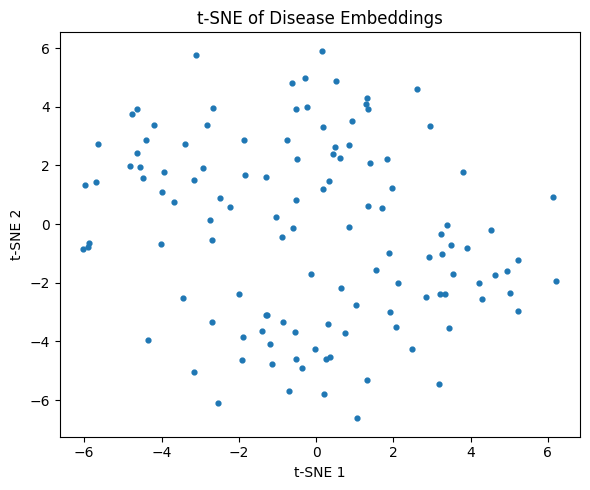

In [15]:
# t-SNE of disease embeddings
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

E = np.load("disease_embeddings.npy")              # shape: [num_codes, d]
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=0)
Z = tsne.fit_transform(E)

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], s=12)
plt.title("t-SNE of Disease Embeddings")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("fig_disease_tsne.png", dpi=300)
plt.show()


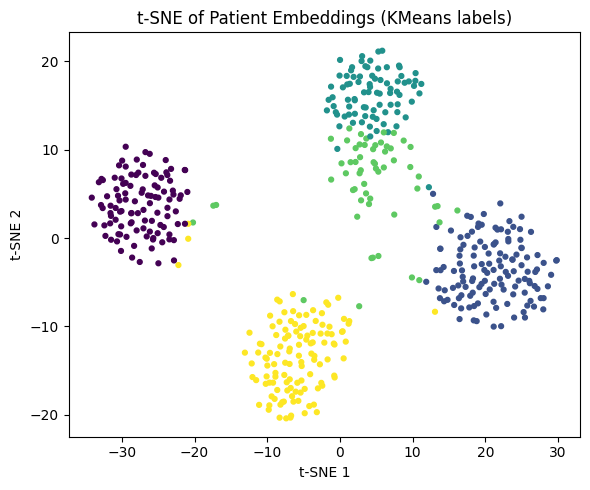

In [16]:
# t-SNE of patient embeddings with KMeans clusters
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pe = np.load("patient_embeddings.npy", allow_pickle=True).item()
P_ids = list(pe.keys())
X = np.vstack([pe[k] for k in P_ids])

kmeans = KMeans(n_clusters=5, n_init=10, random_state=0).fit(X)
labels = kmeans.labels_

tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=0)
Zp = tsne.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(Zp[:,0], Zp[:,1], s=12, c=labels)
plt.title("t-SNE of Patient Embeddings (KMeans labels)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("fig_patient_tsne_kmeans.png", dpi=300)
plt.show()


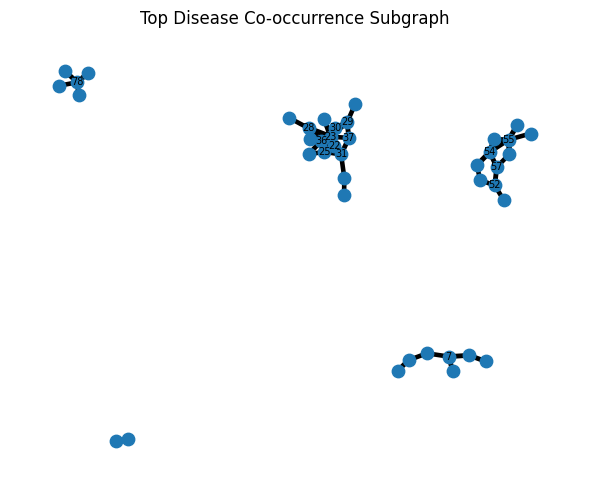

In [17]:
# Small disease co-occurrence subgraph visualization
import json, numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

with open("data/sample/patient_to_codes.json") as f:
    p2c = json.load(f)

num_pat = len(p2c)
code_freq = Counter()
pair_freq = Counter()
for codes in p2c.values():
    codes = sorted(set(codes))
    for c in codes: code_freq[c]+=1
    for i,j in combinations(codes,2):
        if i>j: i,j=j,i
        pair_freq[(i,j)]+=1

# keep top 50 edges by frequency
top_pairs = sorted(pair_freq.items(), key=lambda x: x[1], reverse=True)[:50]
G = nx.Graph()
for (i,j), w in top_pairs:
    G.add_edge(i,j,weight=w)

plt.figure(figsize=(6,5))
pos = nx.spring_layout(G, seed=0)
nx.draw_networkx_nodes(G, pos, node_size=80)
nx.draw_networkx_edges(G, pos, width=[0.5+0.2*G[u][v]['weight'] for u,v in G.edges()])
# label only high-degree nodes
deg = dict(G.degree())
lbls = {n:str(n) for n,d in deg.items() if d>=3}
nx.draw_networkx_labels(G, pos, labels=lbls, font_size=7)
plt.title("Top Disease Co-occurrence Subgraph")
plt.axis("off")
plt.tight_layout()
plt.savefig("fig_disease_cooccurrence_graph.png", dpi=300)
plt.show()


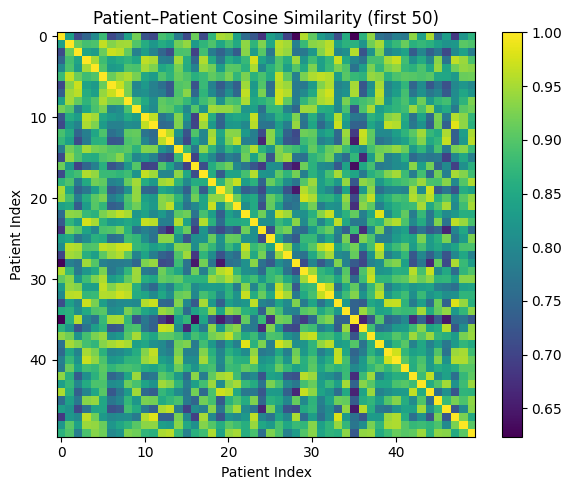

In [18]:
# Patient–patient cosine similarity heatmap (first 50)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

pe = np.load("patient_embeddings.npy", allow_pickle=True).item()
X = np.vstack(list(pe.values()))
X50 = X[:50]
S = cosine_similarity(X50)

plt.figure(figsize=(6,5))
plt.imshow(S, aspect="auto")
plt.title("Patient–Patient Cosine Similarity (first 50)")
plt.xlabel("Patient Index"); plt.ylabel("Patient Index")
plt.colorbar()
plt.tight_layout()
plt.savefig("fig_patient_similarity_heatmap.png", dpi=300)
plt.show()


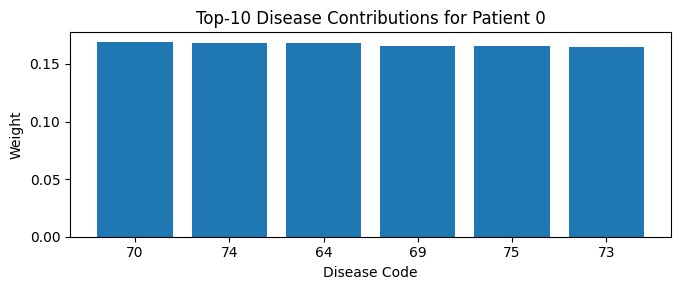

In [19]:
# Bar chart: top-10 disease contributions for a selected patient
import json, numpy as np, matplotlib.pyplot as plt
pid = "0"  # change as needed

E = np.load("disease_embeddings.npy")
with open("data/sample/patient_to_codes.json") as f:
    p2c = json.load(f)
codes = p2c[pid]

# heuristic "attention": L2 norm of disease embeddings followed by softmax
H = E[codes]
scores = np.linalg.norm(H, axis=1)
alpha = np.exp(scores) / np.sum(np.exp(scores))

order = np.argsort(alpha)[::-1][:10]
top_codes = [str(codes[i]) for i in order]
top_alpha = alpha[order]

plt.figure(figsize=(7,3))
plt.bar(range(len(top_codes)), top_alpha)
plt.xticks(range(len(top_codes)), top_codes, rotation=0)
plt.title(f"Top-10 Disease Contributions for Patient {pid}")
plt.xlabel("Disease Code"); plt.ylabel("Weight")
plt.tight_layout()
plt.savefig("fig_patient_attention_bars.png", dpi=300)
plt.show()
